<a href="https://colab.research.google.com/github/gekoramy/uni.deep-learning/blob/standard-finetuning/standard_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Standard finetuning
In this notebook we propose the straightforward solution to fine tune CLIP. The general idea is to add linear layer(s) on top of the 1024 visual features of CLIP.

Dependences

In [33]:
%%shell
tee requirements.txt << END
ftfy
jaxtyping
jupyter
matplotlib
pydantic
regex
torch
torchvision
torchinfo
tqdm
END

pip install -q -r requirements.txt
pip install -q git+https://github.com/openai/CLIP.git
pip install -q ultralytics

ftfy
jaxtyping
jupyter
matplotlib
pydantic
regex
torch
torchvision
torchinfo
tqdm
  Preparing metadata (setup.py) ... done


In [57]:
import clip
import json
import os
import pickle
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import PIL

from datetime import datetime
from jaxtyping import Float, UInt, Int
from pydantic.dataclasses import dataclass
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchinfo import summary
from typing import Literal, Callable, Mapping, TypeVar
from tqdm import tqdm

In [4]:
device: Literal['cpu', 'cuda'] = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
device

'cpu'

## Load the dataset
First of all we have to load the dataset.

In [5]:
%%shell
if ! [ -d dataset ]; then
  mkdir dataset &&
  gdown 1P8a1g76lDJ8cMIXjNDdboaRR5-HsVmUb &&
  tar -xf refcocog.tar.gz -C dataset &&
  rm refcocog.tar.gz
fi

Downloading...
From: https://drive.google.com/uc?id=1P8a1g76lDJ8cMIXjNDdboaRR5-HsVmUb
To: /content/refcocog.tar.gz
100% 13.5G/13.5G [02:34<00:00, 87.4MB/s]


Folder paths

In [6]:
root = os.path.join('dataset', 'refcocog', '')
data_instances = os.path.join(root, 'annotations', 'instances.json')
data_refs = os.path.join(root, 'annotations', 'refs(umd).p')
data_images = os.path.join(root, 'images', '')

Type declaration

In [7]:
I = TypeVar('I')
P = TypeVar('P')
B = TypeVar('B')
T = TypeVar('T')

Img = UInt[torch.Tensor, 'C W H']
BBox = UInt[torch.Tensor, '4']
Split = Literal['train', 'test', 'val']

@dataclass
class Info:
    description: str  # This is stable 1.0 version of the 2014 MS COCO dataset.
    url: str  # http://mscoco.org/
    version: str  # 1.0
    year: int  # 2014
    contributor: str  # Microsoft COCO group
    date_created: datetime  # 2015-01-27 09:11:52.357475

@dataclass
class Image:
    license: int  # each image has an associated licence id
    file_name: str  # file name of the image
    coco_url: str  # example http://mscoco.org/images/131074
    height: int
    width: int
    flickr_url: str  # example http://farm9.staticflickr.com/8308/7908210548_33e
    id: int  # id of the imag
    date_captured: datetime  # example '2013-11-21 01:03:06'

@dataclass
class License:
    url: str  # example http://creativecommons.org/licenses/by-nc-sa/2.0/
    id: int  # id of the licence
    name: str  # example 'Attribution-NonCommercial-ShareAlike License

@dataclass
class Annotation:
    #segmentation: list[list[float]]  # description of the mask; example [[44.17, 217.83, 36.21, 219.37, 33.64, 214.49, 31.08, 204.74, 36.47, 202.68, 44.17, 203.2]]
    area: float  # number of pixel of the described object
    iscrowd: Literal[1, 0]  # Crowd annotations (iscrowd=1) are used to label large groups of objects (e.g. a crowd of people)
    image_id: int  # id of the target image
    bbox: tuple[float, float, float, float]  # bounding box coordinates [xmin, ymin, width, height]
    category_id: int
    id: int  # annotation id

@dataclass
class Category:
    supercategory: str  # example 'vehicle'
    id: int  # category id
    name: str  # example 'airplane'

@dataclass
class Instances:
    info: Info
    images: list[Image]
    licenses: list[License]
    annotations: list[Annotation]
    categories: list[Category]

@dataclass
class Sentence:
    tokens: list[str]  # tokenized version of referring expression
    raw: str  # unprocessed referring expression
    sent: str  # referring expression with mild processing, lower case, spell correction, etc.
    sent_id: int  # unique referring expression id

@dataclass
class Ref:
    image_id: int  # unique image id
    split: Split
    sentences: list[Sentence]
    file_name: str  # file name of image relative to img_root
    category_id: int  # object category label
    ann_id: int  # id of object annotation in instance.json
    sent_ids: list[int]  # same ids as nested sentences[...][sent_id]
    ref_id: int  # unique id for refering expression

In [8]:
#@dataclass
#class Prediction:
#  image
#  description: list[str]  # natural language descriptions of the area of interest
#  ground_truth_bbox: tuple[float, float, float, float] # ground truth bounding box
#  output_bbox: tuple[float, float, float, float] # predicted bounding box

class Prediction:
  def __init__(self, image, description, ground_truth_bbox, output_bbox):
    self.image = image
    self.description = description
    self.ground_truth_bbox = ground_truth_bbox
    self.output_bbox = output_bbox

Read the dataset infos

In [9]:
def fix_ref(x: Ref) -> Ref:
    x.file_name = fix_filename(x.file_name)
    return x


def fix_filename(x: str) -> str:
    """
    :param x: COCO_..._[image_id]_[annotation_id].jpg
    :return:  COCO_..._[image_id].jpg
    """
    return re.sub('_\d+\.jpg$', '.jpg', x)

In [10]:
with open(data_refs, 'rb') as f:
    raw = pickle.load(f)

In [11]:
refs: list[Ref] = [
    fix_ref(Ref(**ref))
    for ref in raw
]

In [12]:
with open(data_instances, 'r') as f:
    raw = json.load(f)

In [13]:
instances: Instances = Instances(**raw)

In [14]:
id2annotation: Mapping[int, Annotation] = {
    x.id: x
    for x in instances.annotations
}

Define custom dataset

In [15]:
class CocoDataset(Dataset[tuple[I, P, B]]):

    def __init__(
        self,
        split: Split,
        img_transform: Callable[[Img], I] = lambda x: x,
        prompt_transform: Callable[[list[Sentence]], P] = lambda ps: [ p.sent for p in ps ],
        bb_transform: Callable[[UInt[torch.Tensor, '4']], B] = lambda x: x
    ):
        """
        :param split: train, test or val
        :param img_transform: apply transformation on the processed images
        :param prompt_transform: apply transformation on the prompts
        :param bb_transform: apply transformation on the bounding box
        """
        self.img_transform = img_transform
        self.prompt_transform = prompt_transform
        self.bb_transform = bb_transform

        # Internally the dataset is a list of tuple[str, list[Sentence], UInt[torch.Tensor, '4']]
        # Such that:
        # str                     : image filename
        # list[Sentence]          : list of reference expression objects
        # UInt[torch.Tensor, '4'] : bounding box
        self.items: list[tuple[str, list[Sentence], UInt[torch.Tensor, '4']]] = [
            (i, ps, o)
            for ref in refs
            if ref.split == split
            for i in [os.path.join(data_images, ref.file_name)]
            for ps in [ref.sentences]
            for o in [torch.tensor(id2annotation[ref.ann_id].bbox, dtype=torch.int)]
        ]


    def __len__(self) -> int:
        return len(self.items)


    def __getitem__(self, item: int) -> tuple[I, P, B]:
        i, ps, b = self.items[item]
        return (
            self.img_transform(read_image(i)),
            self.prompt_transform(ps),
            self.bb_transform(b),
        )

## Training free CLIP results
For the sake of comparison with the implementations below, we have to evaluate CLIP training free with the same portion of the dataset.

Load yolo model

In [ ]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
yolo_model.to(device=device).eval()

Load CLIP model

In [17]:
clip_model, preprocess = clip.load('RN50')
clip_model = clip_model.to(device=device).eval()

100%|████████████████████████████████████████| 244M/244M [00:02<00:00, 125MiB/s]


Baseline evaluation

In [18]:
test_dataset: Dataset[tuple[Img, list[str], UInt[torch.Tensor, '4']]] = CocoDataset(split='test')

In [19]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

Creating DataLoader's with batch size 1 and 2 workers.


In [20]:
MAX_ITER: int = 10 # max number of iterations
current_iteration: int = 0

stored_predictions: list[Prediction] = []

ious: list[float] = []
coss: list[float] = []
euds: list[float] = []

batch: tuple[UInt[torch.Tensor, '1 C W H'], tuple[list[tuple[str]]], UInt[torch.Tensor, '1 4']]

with torch.no_grad():
    for batch in tqdm(iter(test_dataloader)):

        if current_iteration >= MAX_ITER:
          print("Stop iteration: MAX_ITER = "+str(MAX_ITER))
          break;

        print()
        print(f"--- [{current_iteration}] ---")
        current_iteration += 1

        [img], (prompts), [true_xywh] = batch

        [true_xyxy] = torchvision.ops.box_convert(true_xywh.unsqueeze(0), in_fmt='xywh', out_fmt='xyxy')

        img_pil: Image = transforms.ToPILImage()(img)

        # yolo bboxes
        predictions = yolo_model(img_pil)

        # xmin,      ymin,      xmax,      ymax,      confidence, class
        # 274.06390, 231.20389, 392.66345, 372.59018, 0.93251,    23.00000
        bboxes: Float[torch.Tensor, 'X 6'] = predictions.xyxy[0]

        # if empty, put a bbox equal to image size
        if len(bboxes) == 0:
            bboxes = torch.tensor([[0, 0, img.size()[1], img.size()[2], 0, 0]], dtype=torch.float)

        # from yolo bboxes to cropped images
        crops: list[Image] = [
            img_pil.crop((xmin, ymin, xmax, ymax))
            for bbox in bboxes
            for [xmin, ymin, xmax, ymax, _, _] in [bbox.tolist()]
        ]

        # clip preprocess on cropped images
        preprocess_crops: Float[torch.Tensor, 'X 3 244 244'] = torch.stack([
            preprocess(crop)
            for crop in crops
        ]).to(device=device)

        # format each available prompt
        prompts_tokens: Int[torch.Tensor, 'P 77'] = clip.tokenize([
            template.format(prompt)
            for template in ["{}", "A photo of {}", "We can see {}"]
            for (prompt,) in prompts  # <- ¯\_(ツ)_/¯
        ])

        # clip scores
        ass_z: tuple[Float[torch.Tensor, 'X P'], Float[torch.Tensor, 'P X']] = clip_model(preprocess_crops, prompts_tokens)
        _, logits_per_prompt = ass_z

        # final prediction
        best_match: int = torch.argmax(torch.max(logits_per_prompt, 0).values).item()
        prediction_bbox: Float[torch.Tensor, '4'] = bboxes[best_match][:4]

        # metrics
        iou: float = torchvision.ops.box_iou(true_xyxy.unsqueeze(0), prediction_bbox.unsqueeze(0)).item()
        ious.append(iou)

        rectangle: tuple[int, int, int, int] = true_xyxy.tolist()
        ground_truth_crop = img_pil.crop(rectangle)

        rectangle: tuple[int, int, int, int] = torch.tensor(prediction_bbox, dtype=torch.int).tolist()
        prediction_crop = img_pil.crop(rectangle)

        # from float16 to float32
        X: Float[torch.Tensor, '1'] = torch.tensor(
            clip_model.encode_image(torch.tensor(preprocess(ground_truth_crop)).unsqueeze(0)),
            dtype=torch.float
        )
        Y: Float[torch.Tensor, '1'] = torch.tensor(
            clip_model.encode_image(torch.tensor(preprocess(prediction_crop)).unsqueeze(0)),
            dtype=torch.float
        )

        cos: float = F.cosine_similarity(X, Y).item()
        coss.append(cos)

        eud: float = torch.cdist(X, Y, p=2).item()
        euds.append(eud)

        # store the prediction
        pred : Prediction = Prediction(
              image = img,
              description = [p[0] for p in prompts],
              ground_truth_bbox = true_xyxy,
              output_bbox = prediction_bbox
            )
        stored_predictions.append(pred)

        torch.cuda.empty_cache()

  0%|          | 0/5023 [00:00<?, ?it/s]


--- [0] ---


  0%|          | 1/5023 [00:02<4:04:03,  2.92s/it]


--- [1] ---


  0%|          | 2/5023 [00:06<4:13:49,  3.03s/it]


--- [2] ---


  0%|          | 3/5023 [00:17<9:50:02,  7.05s/it]


--- [3] ---


  0%|          | 4/5023 [00:22<8:23:50,  6.02s/it]


--- [4] ---


  0%|          | 5/5023 [00:26<7:40:50,  5.51s/it]


--- [5] ---


  0%|          | 6/5023 [00:29<6:09:21,  4.42s/it]


--- [6] ---


  0%|          | 7/5023 [00:31<4:58:36,  3.57s/it]


--- [7] ---


  0%|          | 8/5023 [00:33<4:17:58,  3.09s/it]


--- [8] ---


  0%|          | 9/5023 [00:35<4:01:51,  2.89s/it]


--- [9] ---


  0%|          | 10/5023 [00:37<5:13:45,  3.76s/it]

Stop iteration: MAX_ITER = 10


In [38]:
prompts_tokens.shape

torch.Size([6, 77])

In [40]:
preprocess_crops.shape

torch.Size([1, 3, 224, 224])

In [21]:
len(stored_predictions)

10

Performance:

In [25]:
print(f"ious: {torch.mean(torch.tensor(ious, dtype=torch.float))}")
print(f"coss: {torch.mean(torch.tensor(coss, dtype=torch.float))}")
print(f"euds: {torch.mean(torch.tensor(euds, dtype=torch.float))}")

ious: 0.8870830535888672
coss: 0.9737337827682495
euds: 0.4665526747703552


Function to display a random sample of predictions.

In [26]:
# args:
#  - predictionList: [Prediction]
#  - numPred: int :: if numPred==-1 (default) consider all the predictions in predictionList
def display_predictions(predictionList, numPred=-1):
  limit = 0
  for p in predictionList:
    if numPred!=-1 and limit >= numPred:
      return;
    limit += 1

    p_image = p.image
    p_description = p.description
    p_ground_truth_bbox = p.ground_truth_bbox
    p_output_bbox = p.output_bbox

    # TODO: concatenate
    p_image = draw_bounding_boxes(p_image, p_ground_truth_bbox.unsqueeze(0), colors="green", width=5)
    p_image = draw_bounding_boxes(p_image, p_output_bbox.unsqueeze(0), colors="red", width=5)

    tensor_to_pil = transforms.ToPILImage()
    image_pil = tensor_to_pil(p_image)
    display(image_pil)
    print(p_description)
    print("\n\n")

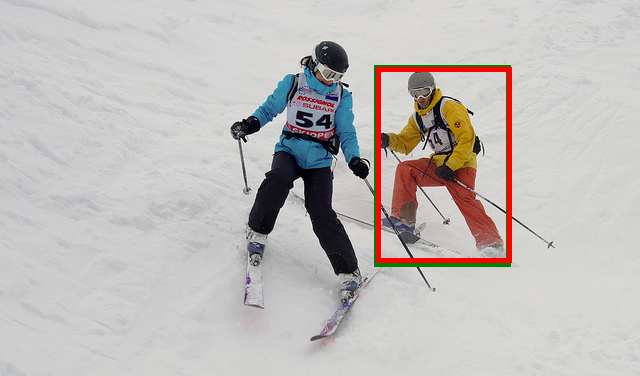

['the man in yellow coat', 'skiier in red pants']





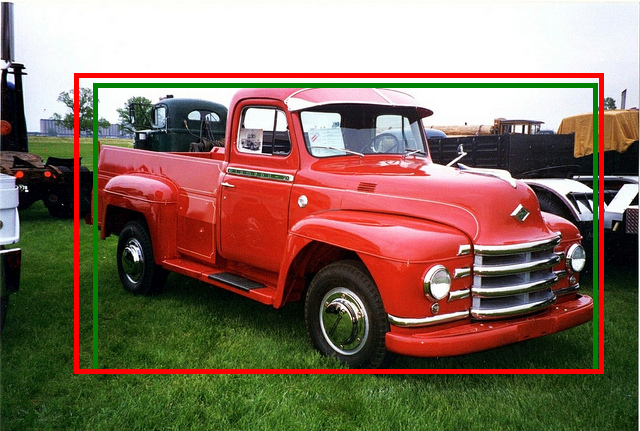

['there is red colored truck in between the other trucks', 'a shiny red vintage pickup truck']





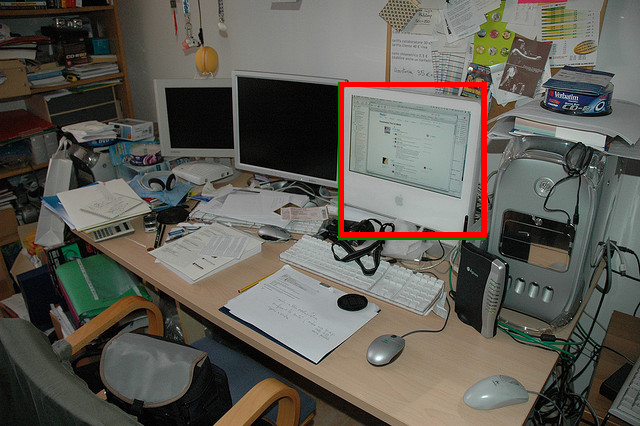

['a apple desktop computer', 'the white imac computer that is also turned on']





In [29]:
display_predictions(stored_predictions, 3)

## Linear layers on top of image encoder

In [43]:
summary(clip_model.visual, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ModifiedResNet                           [1, 3, 224, 224]          [1, 1024]                 --                        True
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
├─BatchNorm2d: 1-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
├─ReLU: 1-3                              [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
├─Conv2d: 1-4                            [1, 32, 112, 112]         [1, 32, 112, 112]         9,216                     True
├─BatchNorm2d: 1-5                       [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
├─ReLU: 1-6                              [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
├─Conv2

In [56]:
summary(clip_model.transformer, input_size=(77,512), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Transformer                              [77, 512]                 [77, 512]                 --                        True
├─Sequential: 1-1                        [77, 512]                 [77, 512]                 --                        True
│    └─ResidualAttentionBlock: 2-1       [77, 512]                 [77, 512]                 --                        True
│    │    └─LayerNorm: 3-1               [77, 512]                 [77, 512]                 1,024                     True
│    │    └─MultiheadAttention: 3-2      [77, 512]                 [77, 512]                 1,050,624                 True
│    │    └─LayerNorm: 3-3               [77, 512]                 [77, 512]                 1,024                     True
│    │    └─Sequential: 3-4              [77, 512]                 [77, 512]                 2,099,712                 True
│  

In the following cell we create a neural network that builds a linear head on top of the visual encoder of CLIP.

In [63]:
class CLIP_SF_image_encoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    model, _ = clip.load("RN50")

    # take the visual encoder of CLIP
    # we also convert it to be 32 bit (by default CLIP is 16)
    self.encoder = model.visual

    # Freeze all pretrained layers by setting requires_grad=False
    for param in self.encoder.parameters():
      param.requires_grad = False

    # add a linear layer
    self.fc1 = nn.Linear(1024, 1024)
    self.fc2 = nn.Linear(1024, 1024)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # visual encoder
    with torch.no_grad():
      x = self.encoder(x)
    # ---

    # linear head
    x = self.fc1(x)
    x = F.relu(x)

    x = self.fc2(x)
    # ---

    return x

In [64]:
net = CLIP_SF_image_encoder().to(device)

In [65]:
summary(net, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
CLIP_SF_image_encoder                         [1, 3, 224, 224]          [1, 1024]                 --                        Partial
├─ModifiedResNet: 1-1                         [1, 3, 224, 224]          [1, 1024]                 --                        False
│    └─Conv2d: 2-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    └─BatchNorm2d: 2-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    └─ReLU: 2-3                              [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Conv2d: 2-4                            [1, 32, 112, 112]         [1, 32, 112, 112]         (9,216)                   False
│    └─BatchNorm2d: 2-5                       [1, 32, 112, 112]         [1, 32, 112, 11

In [66]:
def get_optimizer(model, lr, wd, momentum):
  optimizer = torch.optim.SGD([
      {'params': model.classifier.parameters(), 'lr': lr}
  ], lr=lr / 10, weight_decay=wd, momentum=momentum)

  return optimizer

In [67]:
def get_cost_function():
  def iou_loss(bbox_prediction, bbox_groundtruth):
    return torchvision.ops.box_iou(bbox_groundtruth, bbox_prediction).item()

  return iou_loss

In [ ]:
def training_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device):
  train_loss = 0.0
  #train_acc = 0.0 #todo riflettere anche su questo

  model.to(device)
  for batch_idx, img, prompts, true_xywh in enumerate(data_loader):
    # send data to target device
    img = img.to(device)
    prompts = prompts.to(device)
    true_xywh = true_xywh.to(device)
    [true_xyxy] = torchvision.ops.box_convert(true_xywh.unsqueeze(0), in_fmt='xywh', out_fmt='xyxy')

    # forward pass
    img_pil: Image = transforms.ToPILImage()(img)

    # yolo bboxes
    predictions = yolo_model(img_pil)

    # xmin,      ymin,      xmax,      ymax,      confidence, class
    # 274.06390, 231.20389, 392.66345, 372.59018, 0.93251,    23.00000
    bboxes: Float[torch.Tensor, 'X 6'] = predictions.xyxy[0]

    # if empty, put a bbox equal to image size
    if len(bboxes) == 0:
        bboxes = torch.tensor([[0, 0, img.size()[1], img.size()[2], 0, 0]], dtype=torch.float)

    # from yolo bboxes to cropped images
    crops: list[Image] = [
        img_pil.crop((xmin, ymin, xmax, ymax))
        for bbox in bboxes
        for [xmin, ymin, xmax, ymax, _, _] in [bbox.tolist()]
    ]

    # clip preprocess on cropped images
    preprocess_crops: Float[torch.Tensor, 'X 3 244 244'] = torch.stack([
        preprocess(crop)
        for crop in crops
    ]).to(device=device)

    # format each available prompt
    prompts_tokens: Int[torch.Tensor, 'P 77'] = clip.tokenize([
        template.format(prompt)
        for template in ["{}", "A photo of {}", "We can see {}"]
        for (prompt,) in prompts  # <- ¯\_(ツ)_/¯
    ])

    # clip scores
    ass_z: tuple[Float[torch.Tensor, 'X P'], Float[torch.Tensor, 'P X']] = clip_model(preprocess_crops, prompts_tokens)
    _, logits_per_prompt = ass_z

    # final prediction
    best_match: int = torch.argmax(torch.max(logits_per_prompt, 0).values).item()
    prediction_bbox: Float[torch.Tensor, '4'] = bboxes[best_match][:4]

    # metrics
    iou: float = torchvision.ops.box_iou(true_xyxy.unsqueeze(0), prediction_bbox.unsqueeze(0)).item()
    ious.append(iou)

    rectangle: tuple[int, int, int, int] = true_xyxy.tolist()
    ground_truth_crop = img_pil.crop(rectangle)

    rectangle: tuple[int, int, int, int] = torch.tensor(prediction_bbox, dtype=torch.int).tolist()
    prediction_crop = img_pil.crop(rectangle)

    # from float16 to float32
    X: Float[torch.Tensor, '1'] = torch.tensor(
        clip_model.encode_image(torch.tensor(preprocess(ground_truth_crop)).unsqueeze(0)),
        dtype=torch.float
    )
    Y: Float[torch.Tensor, '1'] = torch.tensor(
        clip_model.encode_image(torch.tensor(preprocess(prediction_crop)).unsqueeze(0)),
        dtype=torch.float
    )

    cos: float = F.cosine_similarity(X, Y).item()
    coss.append(cos)

    eud: float = torch.cdist(X, Y, p=2).item()
    euds.append(eud)

    torch.cuda.empty_cache()

## Linear layers on top of text encoder

## Linear layers on top of image encoder and on top of text encoder

## Bottleneck